### Optymalizacja - problem przeszukiwania

Lista skupia się na implementacji dwóch algorytmów z wykorzystaniem heurystyk i jednej metaheurystyki w problemie odnajdywania najkrótszych ścieżek

#### Założenia
Jednym z problemów jest uwzględnienie czasu przesiadki do innej linii lub na pobliski przystanek - tutaj zostały rozważone dwa podejścia, gdzie nie dodajemy czasu przesiadki (0 s.) oraz gdzie go dodajemy (60 s.). Prowadzi to do interesujących wniosków. Kolejnym z założeń jest to, że będąc na przystanku o danej nazwie mogę się przejść na pobliski przystanek o tej samej nazwie - dzięki temu odkrywane jest więcej połączeń. Również w przypadku optymalizacji liczby połączeń przyjęto, że nie ma znaczenia o której pojazd odjeżdża oraz jaki jest czas oczekiwania między przesiadkami.

#### Zbiór testowy
ALgorytmy zostały przetestowane na zbiorze 18-stu przejazdów o różnych poziomach skomplikowania trasy

#### 1. Dijkstra 

Jest to algorytm zachłanny wybierający zawsze węzeł o najmniejszej wartości funkcji kosztu $f$. W tym przypadku wykorzystana została zmodyfikowana implementacja, która jest oparta na kolejce priorytetowej. Modyfikacja polega na tym, że nie inicjalizujemy kolejki wszystkimi wierzchołkami, lecz tylko tymi początkowymi. Porównana też była implementacja, gdzie **nie** przetrzymujemy już odwiedzonych wierzchołków, ale była ona w większości przypadkach wolniejsza.

Sama idea przeszukiwania wierzchołków w optymalizacji czasu sprowadza się do następujących kroków:
1. Zainicjalizuj kolejkę wszystkimi możliwymi przystankami początkowymi - wynika to z tego, że może być wiele przystanków o tej samej nazwie, ale różnych współrzędnych geograficznych. 
2. Wybierz przystanek o najmniejszym koszcie - koszt jest obliczany na podstawie najszybszego połączenia, które nas doprowadzi do tego przystanku
3. Dla tego przystanku rozważ najszybsze połączenia z *wszystkich* przystanków o tej nazwie do sąsiadujących przystanków, które jeszcze nie zostały odwiedzone
4. Dodaj ten przystanek do listy odwiedzonych
2. Powtarzaj póki kolejka nie jest pusta

In [1]:
import pandas as pd
import numpy as np
from ai_data_eng.searching.globals import *
from ai_data_eng.searching.utils import *
import matplotlib.pyplot as plt 
RESULTS = DATA_DIR / 'results-saved'

In [2]:
header = ['start_stop', 'goal_stop', 'commuting_time', 'changes', 'elapsed_time', 'cost', 'change_time']
dij = pd.read_csv(RESULTS / 'dijkstra/summary0', names=header)

In [3]:
dij

,start_stop,goal_stop,commuting_time,changes,elapsed_time,cost,change_time
0,PL. GRUNWALDZKI,most Grunwaldzki,00:01:00,0.0,5.79,00:01:00,0
1,KLECINA,OSIEDLE SOBIESKIEGO,00:54:00,5.0,77.55,00:54:00,0
2,Broniewskiego,Uniwersytet Ekonomiczny,00:32:00,4.0,43.16,00:32:00,0
3,POŚWIĘTNE,Młodych Techników,00:27:00,2.0,19.48,00:27:00,0
4,Śliczna,Marchewkowa,01:01:00,3.0,38.37,01:01:00,0
5,PL. GRUNWALDZKI,Renoma,00:09:00,1.0,10.24,00:09:00,0
6,KOSZAROWA (Szpital),Buforowa-Rondo,02:06:00,6.0,69.09,02:06:00,0
7,Wilczyce - Dębowa,Marszowicka,05:42:00,4.0,86.89,05:42:00,0
8,Zabrodzie - pętla,Wiślańska,01:53:00,6.0,42.98,01:53:00,0
9,Maślicka (Osiedle),Iwiny - Kolejowa,01:08:00,10.0,75.11,01:08:00,0


### 2. A$^{*}$

Implementacja tego algorytmu różni się od tej teoretycznej - jest również oparta na kolejce priorytetowej, gdzie waga wierzchołka jest równa $f + g$, gdzie g to użyta heurystyka. 

##### Optymalizacja czasu 
W tym przypadku logika jest podobna jak w dijkstrze, gdzie użyta heurystyka stara się oszacować pozostały czas. Jest to trudne ponieważ nie wiemy z jaką prędkością porusza się środek transportu oraz jak zawiła jest jego trasa. Na podstawie eksperymentów została wybrana heurystyka, która przyjmuje dwa hiperparametry - $v$ oraz $alpha$, gdzie $v$ to początkowa, przeszacowana prędkość a $alpha$ to mały współczynnik aktualizacji prędkości o chwilową prędkość aktualnego połączenia. Jest to więc heurystyka 'ucząca' się a parametry zostały wybrane na podstawie paru różnych tras. Problemem jest jednak udowodnienie, że jest to heurystyka optymistyczna, więc najlepszym środkiem jest porównanie wyników do działania dijsktry

In [4]:
a_star_t = pd.read_csv(RESULTS / 'a-star-t/summary0', names=header)

In [5]:
a_star_t

,start_stop,goal_stop,commuting_time,changes,elapsed_time,cost,change_time
0,PL. GRUNWALDZKI,most Grunwaldzki,00:01:00,0.0,5.59,00:01:00,0
1,KLECINA,OSIEDLE SOBIESKIEGO,00:54:00,5.0,19.81,00:54:00,0
2,Broniewskiego,Uniwersytet Ekonomiczny,00:32:00,4.0,19.03,00:32:00,0
3,POŚWIĘTNE,Młodych Techników,00:27:00,2.0,11.31,00:27:00,0
4,Śliczna,Marchewkowa,01:01:00,3.0,30.56,01:01:00,0
5,PL. GRUNWALDZKI,Renoma,00:09:00,1.0,8.09,00:09:00,0
6,KOSZAROWA (Szpital),Buforowa-Rondo,02:06:00,6.0,40.99,02:06:00,0
7,Wilczyce - Dębowa,Marszowicka,05:43:00,4.0,75.27,05:43:00,0
8,Zabrodzie - pętla,Wiślańska,01:53:00,6.0,22.76,01:53:00,0
9,Maślicka (Osiedle),Iwiny - Kolejowa,01:08:00,10.0,33.25,01:08:00,0


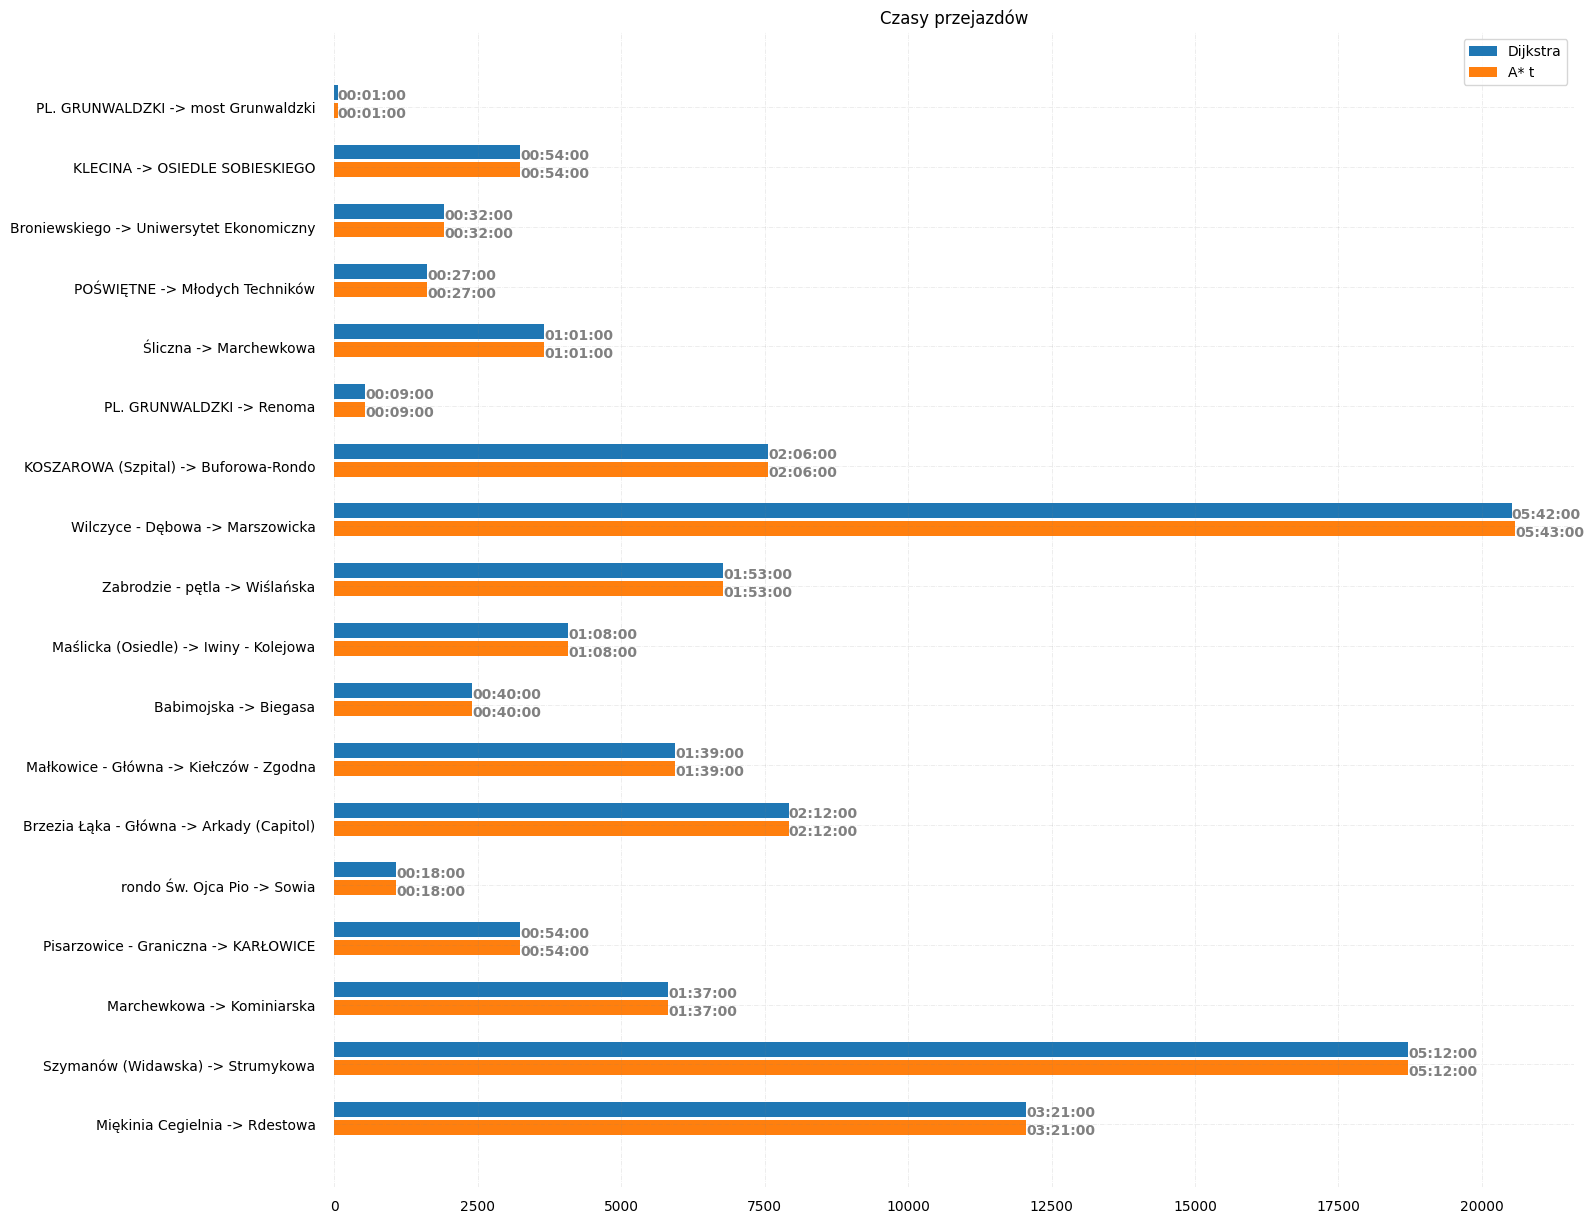

In [6]:
def bar_plot_compare(algorithms, names, col_idx, title, formatter, display_annotation=False):
    fig, ax = plt.subplots(figsize =(16, 15))
    bar_width = 0.25
    spacing = 0.3
    n = len(algorithms[0])
    
    for i, (alg, name) in enumerate(zip(algorithms, names)):
    # Horizontal Bar Plot
        x = i * spacing + np.arange(len(alg))
        ax.barh(x, alg.iloc[:, col_idx].apply(formatter), bar_width, 
                label=f'{name}')
        
    x = bar_width + np.arange(n)
    plt.yticks(x, algorithms[0]['start_stop'] + ' -> ' + (algorithms[0]['goal_stop']))
     
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
     
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
     
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
     
    # Add x, y gridlines
    ax.grid(color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
     
    # Show top values 
    ax.invert_yaxis()
     
    # Add annotation to bars
    if display_annotation:
        for j, i in enumerate(ax.patches):
            plt.text(i.get_width()+0.5, i.get_y() + bar_width, 
                     algorithms[j // n].iloc[j % n, col_idx],
                     fontsize = 10, fontweight ='bold',
                     color ='grey')
     
    # Add Plot Title
    ax.set_title(title)
     
    plt.legend()
    # Show Plot
    plt.show()
    
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=2, title='Czasy przejazdów', formatter=time_to_normalized_sec, display_annotation=True)

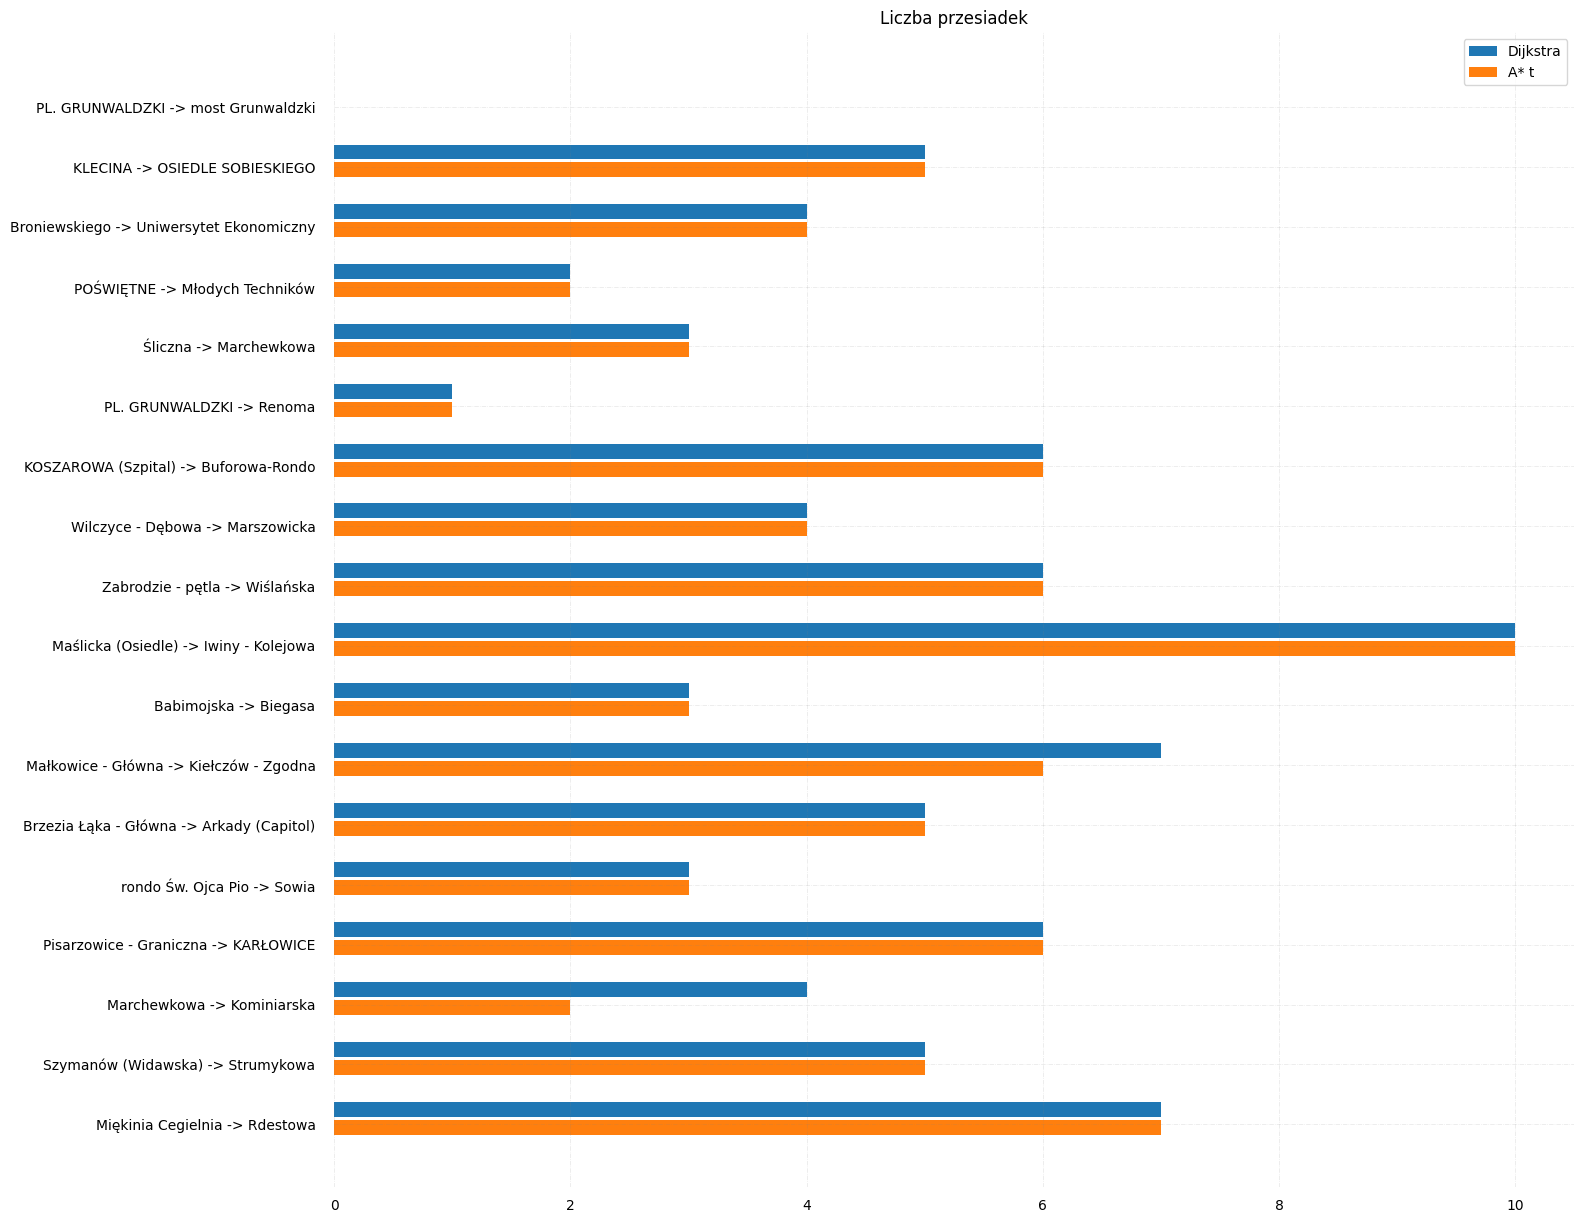

In [7]:
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=False)

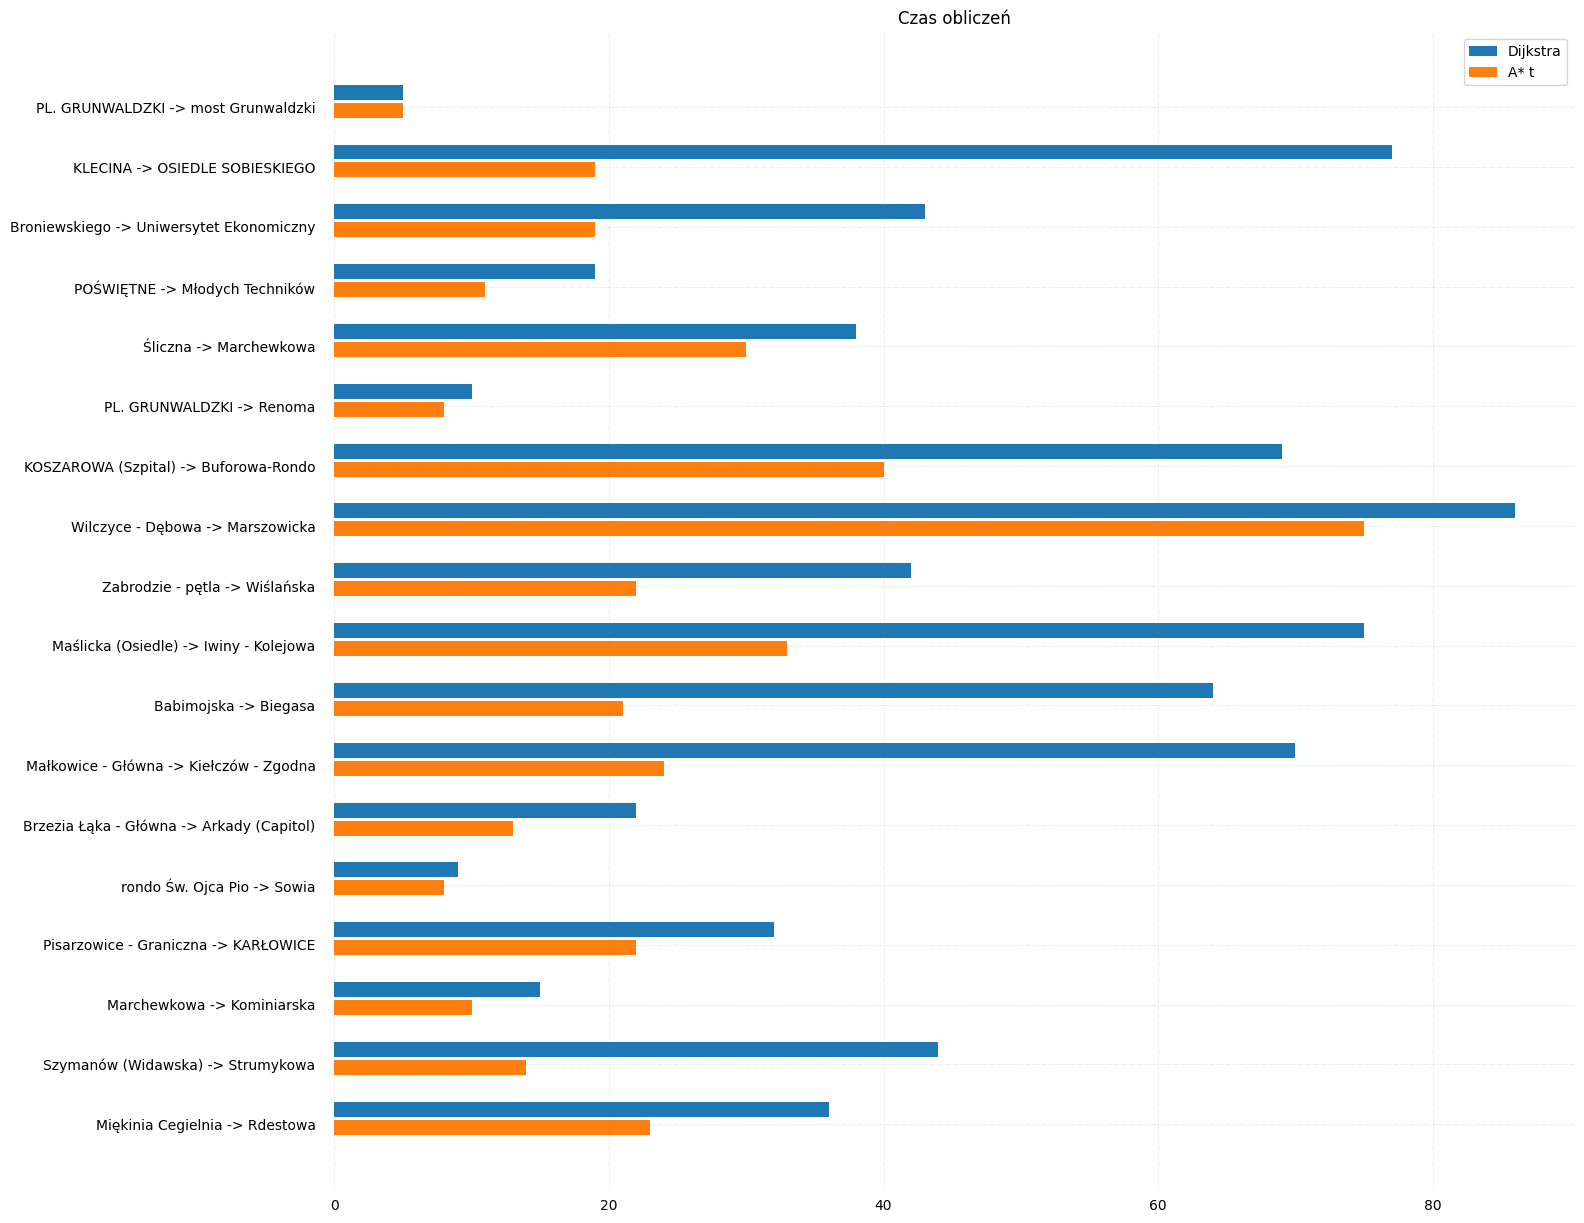

In [8]:
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

#### Modyfikacja - dodanie czasu przesiadki 

W celu urealnienia sytuacji zmiany linii dodano do algorytmów stałą wartość przesiadki - 1 min. Można zauważyć, że zadziałało to w sposób regulujący liczbę przesiadek w algorytmach z optymalizacją tylko czasu, ale w niektórych przypadkach zwiększyło czas przejazdu. 

In [9]:
a_star_t_60 = pd.read_csv(RESULTS / 'a-star-t/summary60', names=header)
dij_60 = pd.read_csv(RESULTS / 'dijkstra/summary60', names=header)

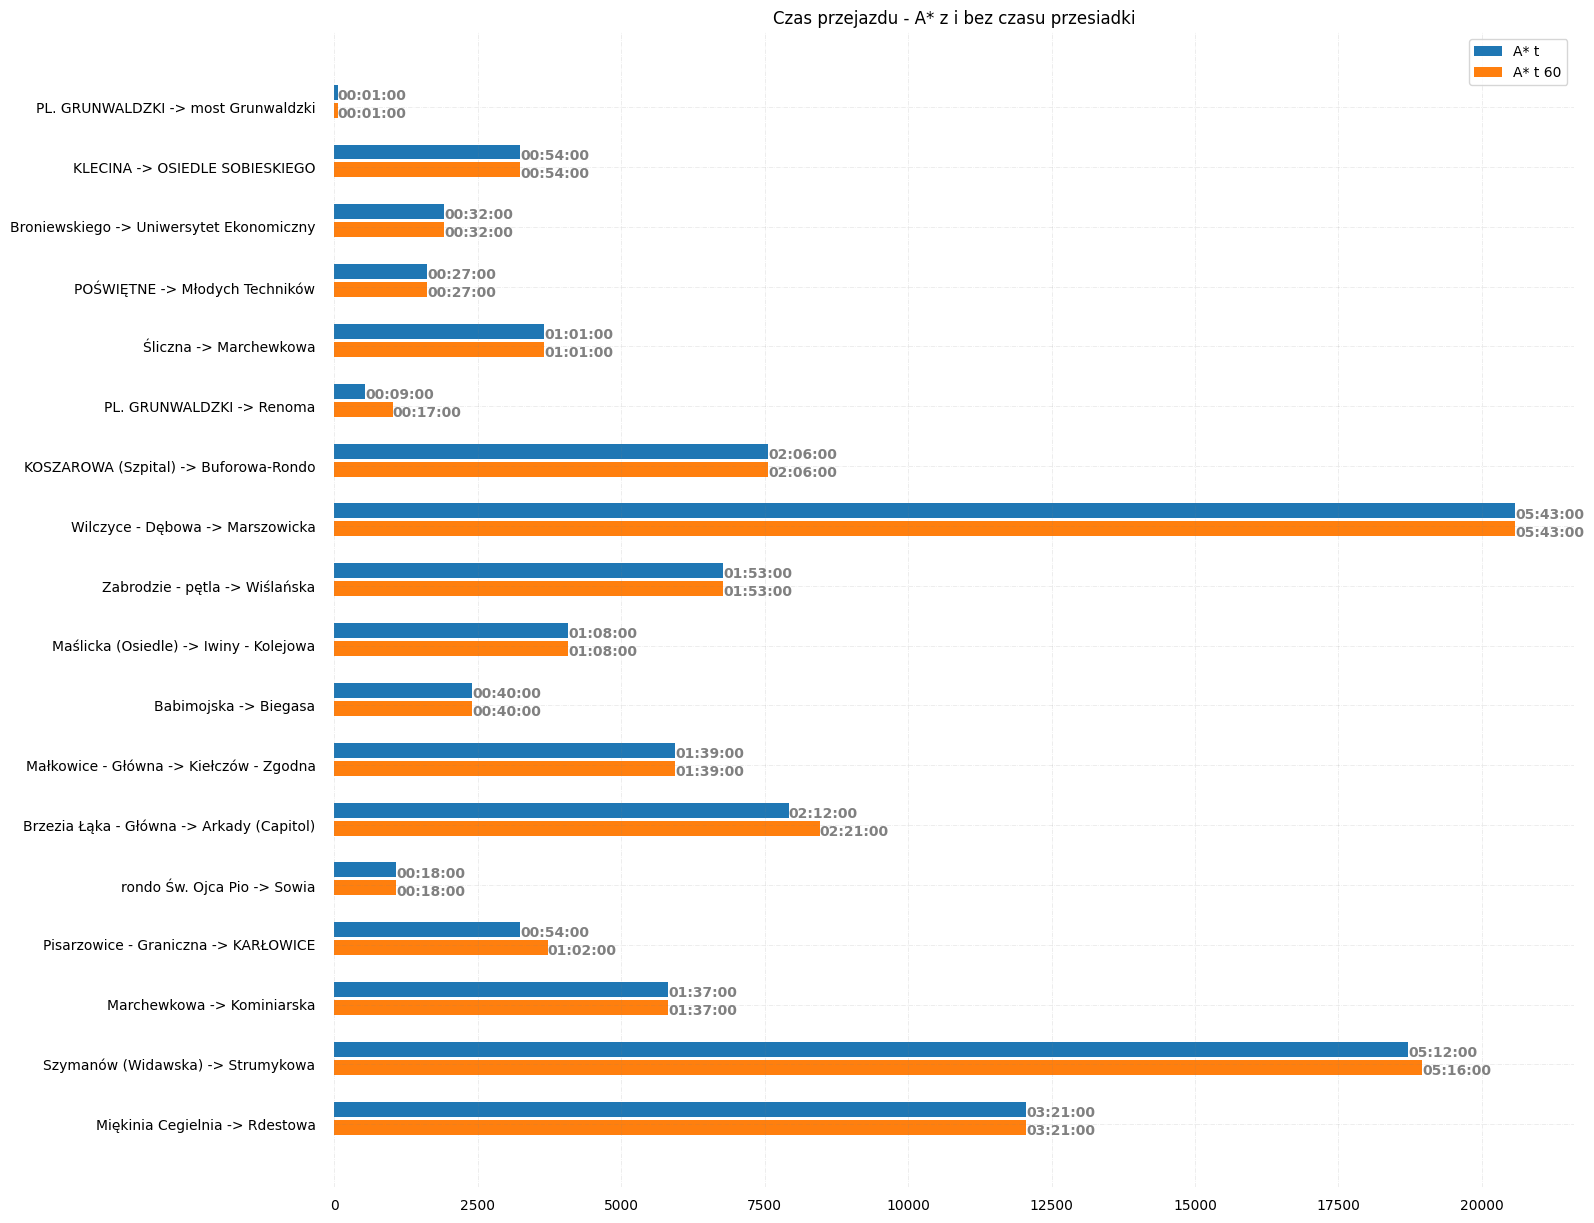

In [10]:
bar_plot_compare([a_star_t, a_star_t_60], ['A* t', 'A* t 60'], col_idx=2, title='Czas przejazdu - A* z i bez czasu przesiadki', 
                 formatter=time_to_normalized_sec, display_annotation=True)

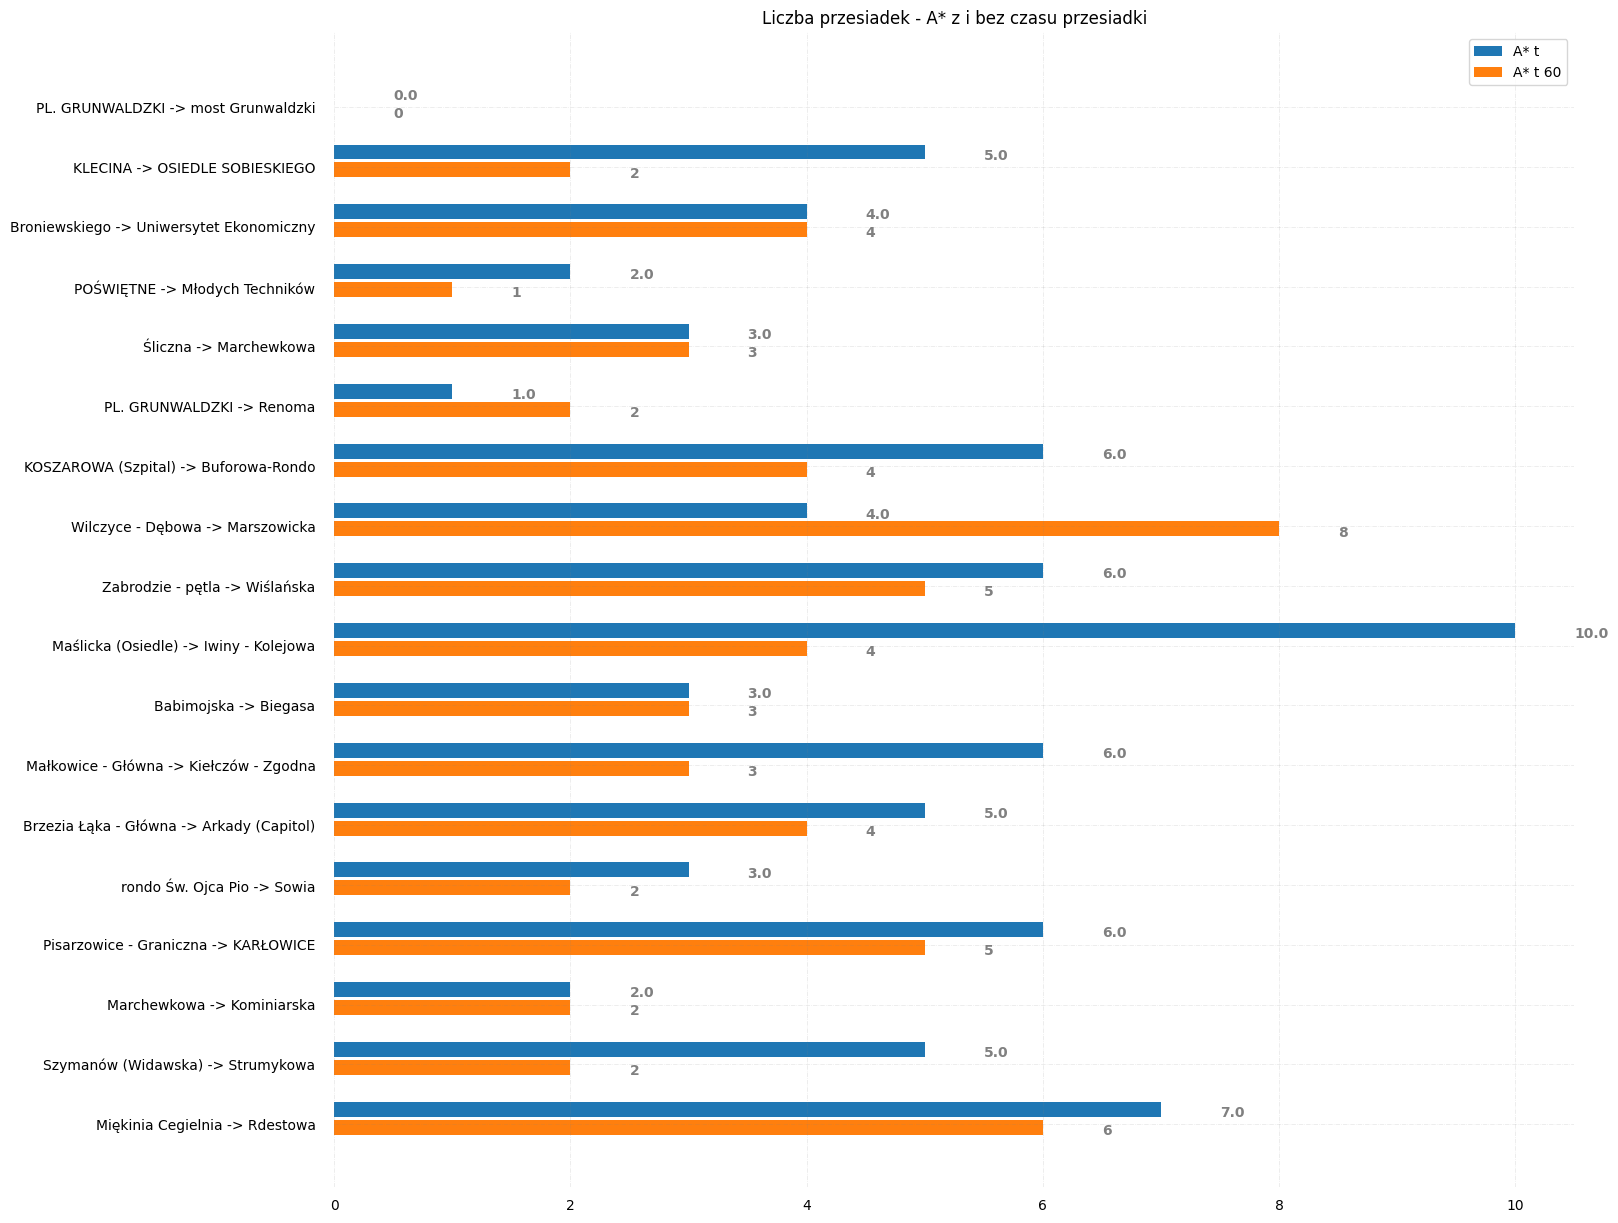

In [11]:
bar_plot_compare([a_star_t, a_star_t_60], ['A* t', 'A* t 60'], col_idx=3, title='Liczba przesiadek - A* z i bez czasu przesiadki', 
                 formatter=int, display_annotation=True)

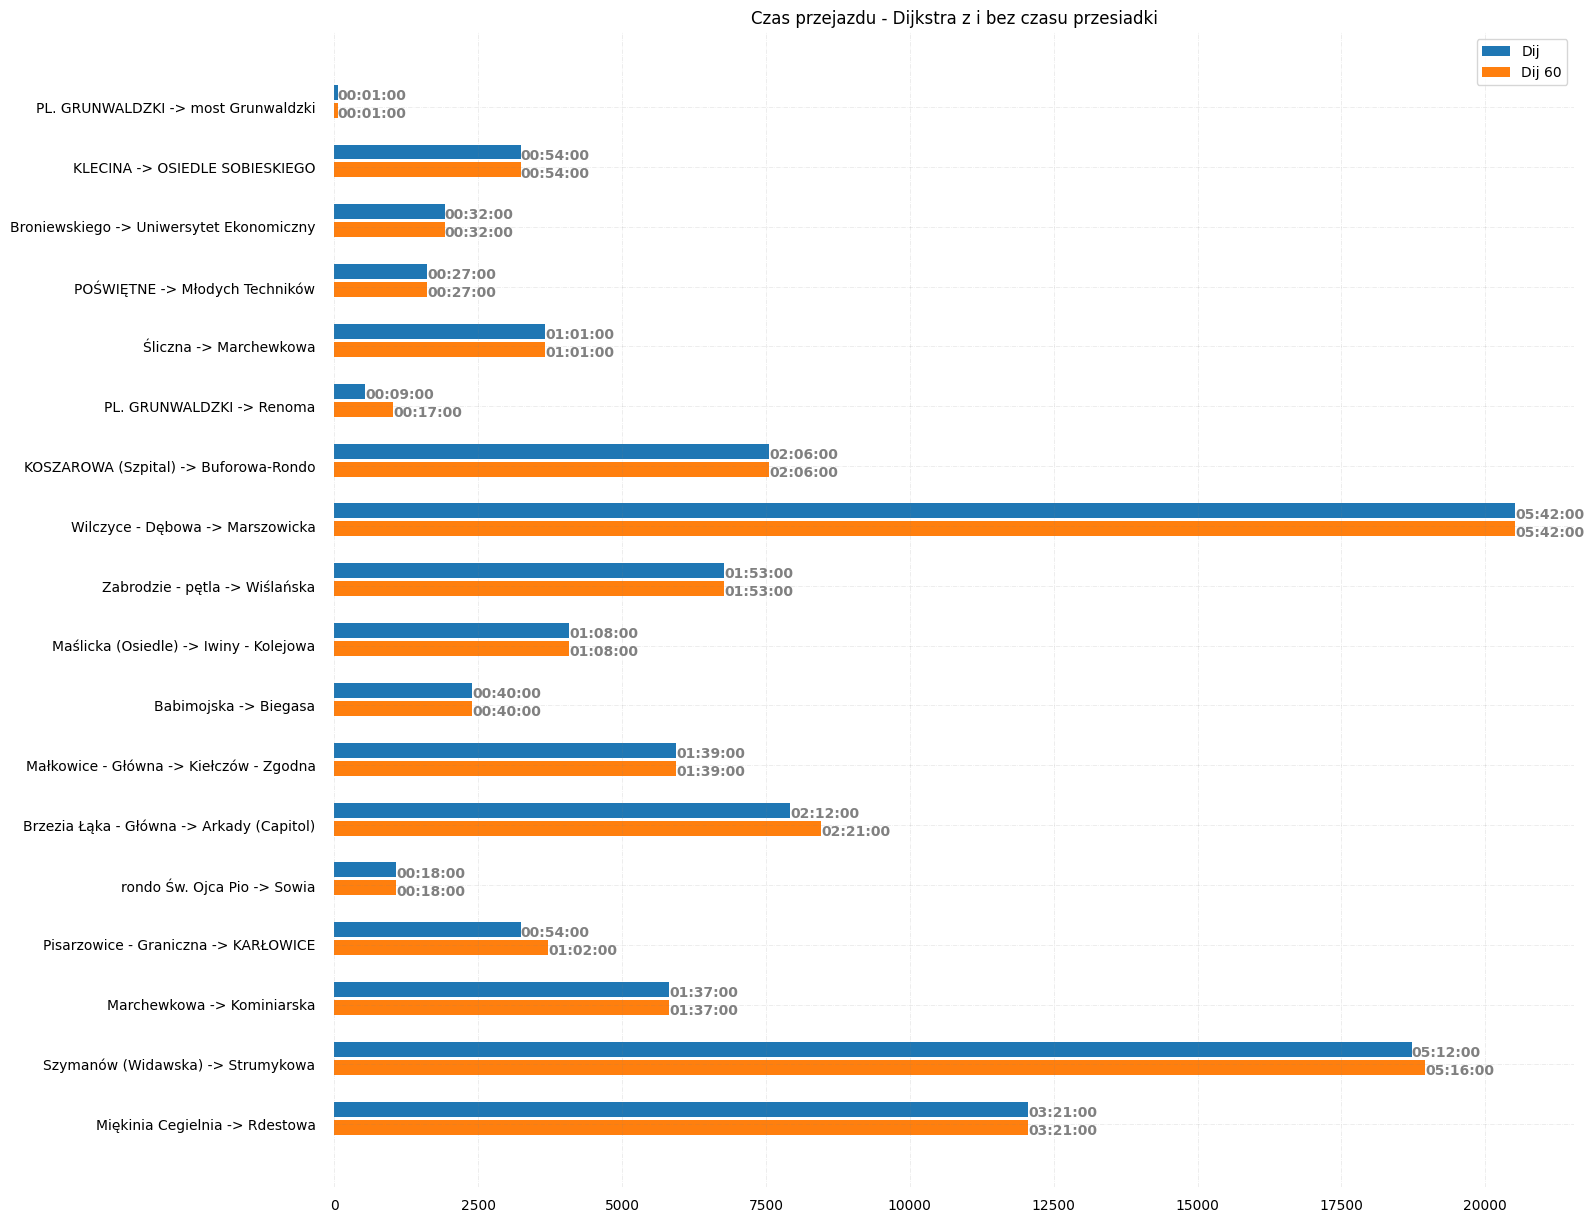

In [12]:
bar_plot_compare([dij, dij_60], ['Dij', 'Dij 60'], col_idx=2, title='Czas przejazdu - Dijkstra z i bez czasu przesiadki', 
                 formatter=time_to_normalized_sec, display_annotation=True)

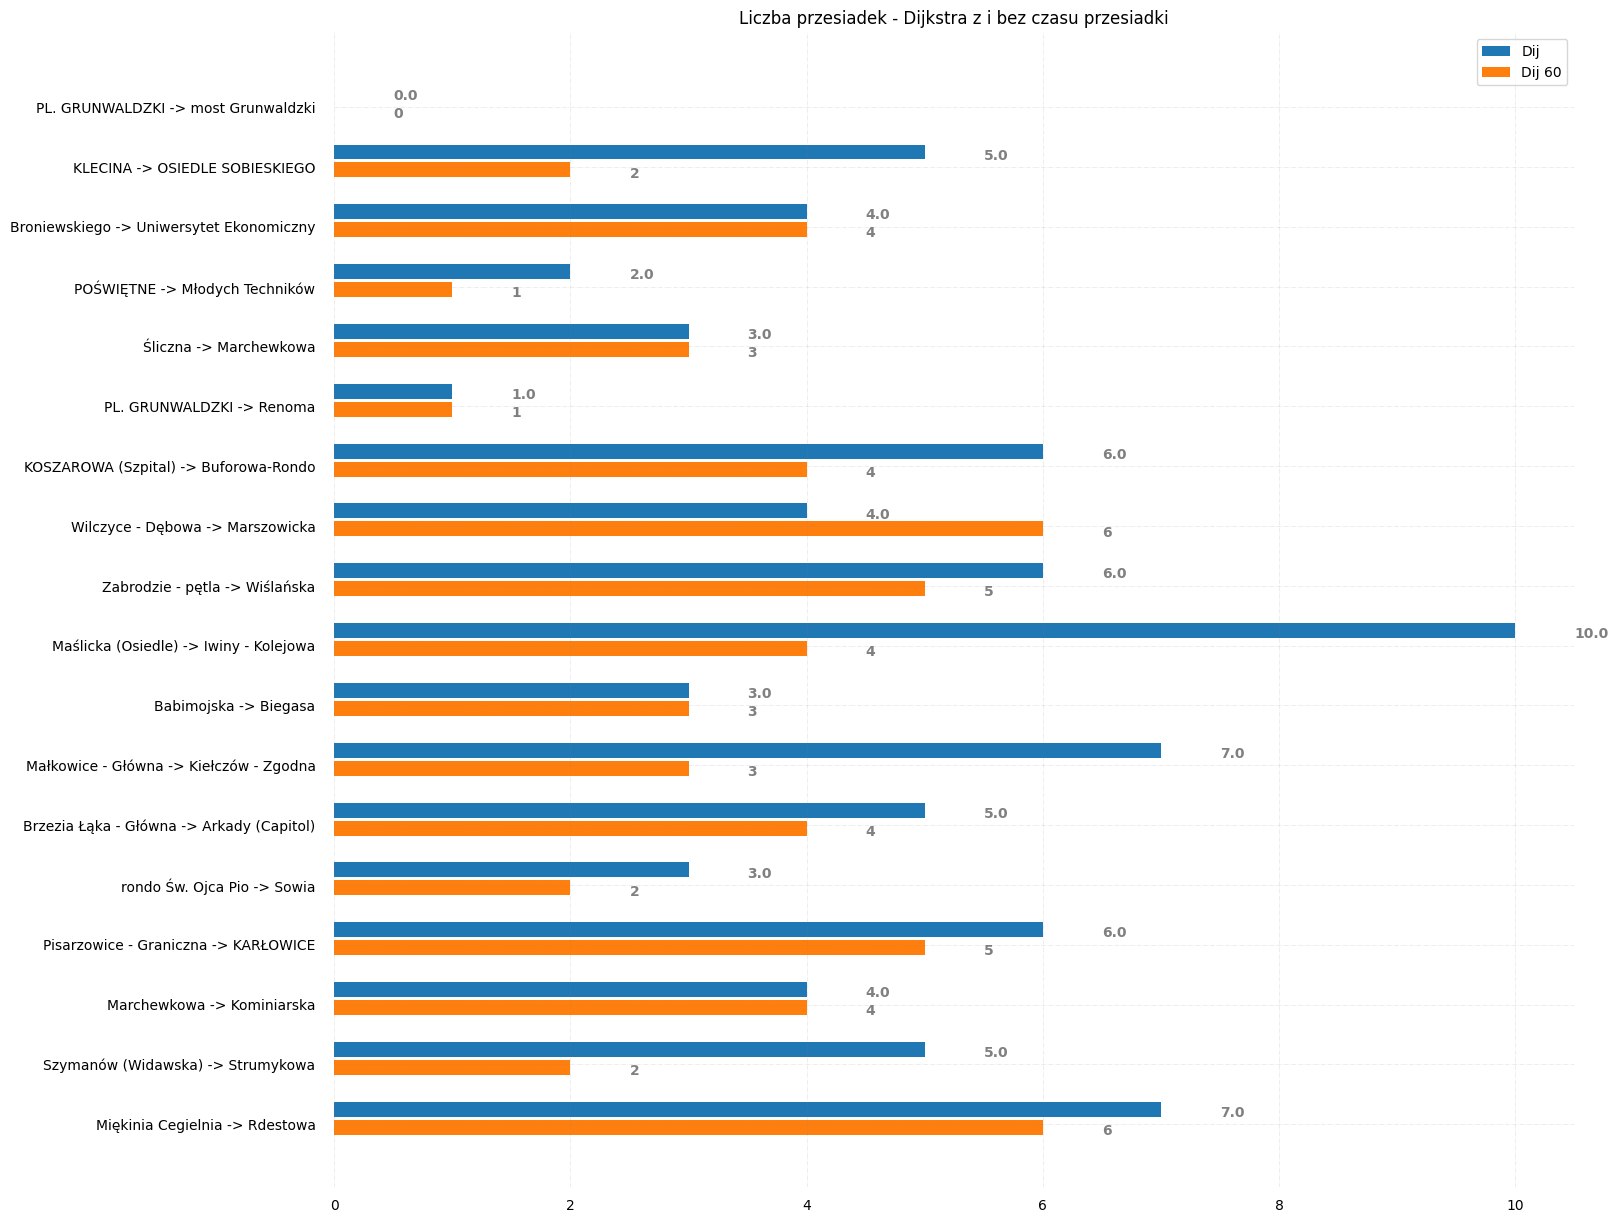

In [13]:
bar_plot_compare([dij, dij_60], ['Dij', 'Dij 60'], col_idx=3, title='Liczba przesiadek - Dijkstra z i bez czasu przesiadki', 
                 formatter=int, display_annotation=True)

#### Optymalizacja przesiadek
Ta postać problemu była bardziej skomplikowana ponieważ definicja przesiadki nie jest oczywista. W tym przypadku uznano, że doszło do przesiadki gdy
- nastąpiła zmiana lini
- nastąpiło przejście do sąsiedniego przystanku
- czas między przyjazdem a odjazdem jest 'długi' (bez tego wpadamy w przejazdy z innego kursu), jako maksymalną długość przejazdu między przystankami przyjęto 99 percentyl czasu między przejazdami dla tego zbioru, czyli 4 minuty.

Heurystyka polega na oszacowaniu liczby przesiadek w zależności od odległości od przystanku końcowego i aktualnej, już dokonanej liczby przesiadek. 

In [14]:
a_star_p = pd.read_csv(DATA_DIR / 'results/a-star-p/summary0', names=header)

In [15]:
a_star_p

,start_stop,goal_stop,commuting_time,changes,elapsed_time,cost,change_time
0,PL. GRUNWALDZKI,most Grunwaldzki,00:01:00,0,5.74,0,0
1,KLECINA,OSIEDLE SOBIESKIEGO,00:54:00,0,87.47,0,0
2,Broniewskiego,Uniwersytet Ekonomiczny,00:37:00,0,73.87,0,0
3,POŚWIĘTNE,Młodych Techników,13:11:00,1,128.75,1,0
4,Śliczna,Marchewkowa,04:54:00,1,109.99,1,0
5,PL. GRUNWALDZKI,Renoma,00:09:00,0,19.68,0,0
6,KOSZAROWA (Szpital),Buforowa-Rondo,02:06:00,1,132.48,1,0
7,Wilczyce - Dębowa,Marszowicka,07:28:00,3,2133.94,3,0
8,Zabrodzie - pętla,Wiślańska,09:04:00,2,680.15,2,0
9,Maślicka (Osiedle),Iwiny - Kolejowa,14:58:00,3,4259.38,3,0


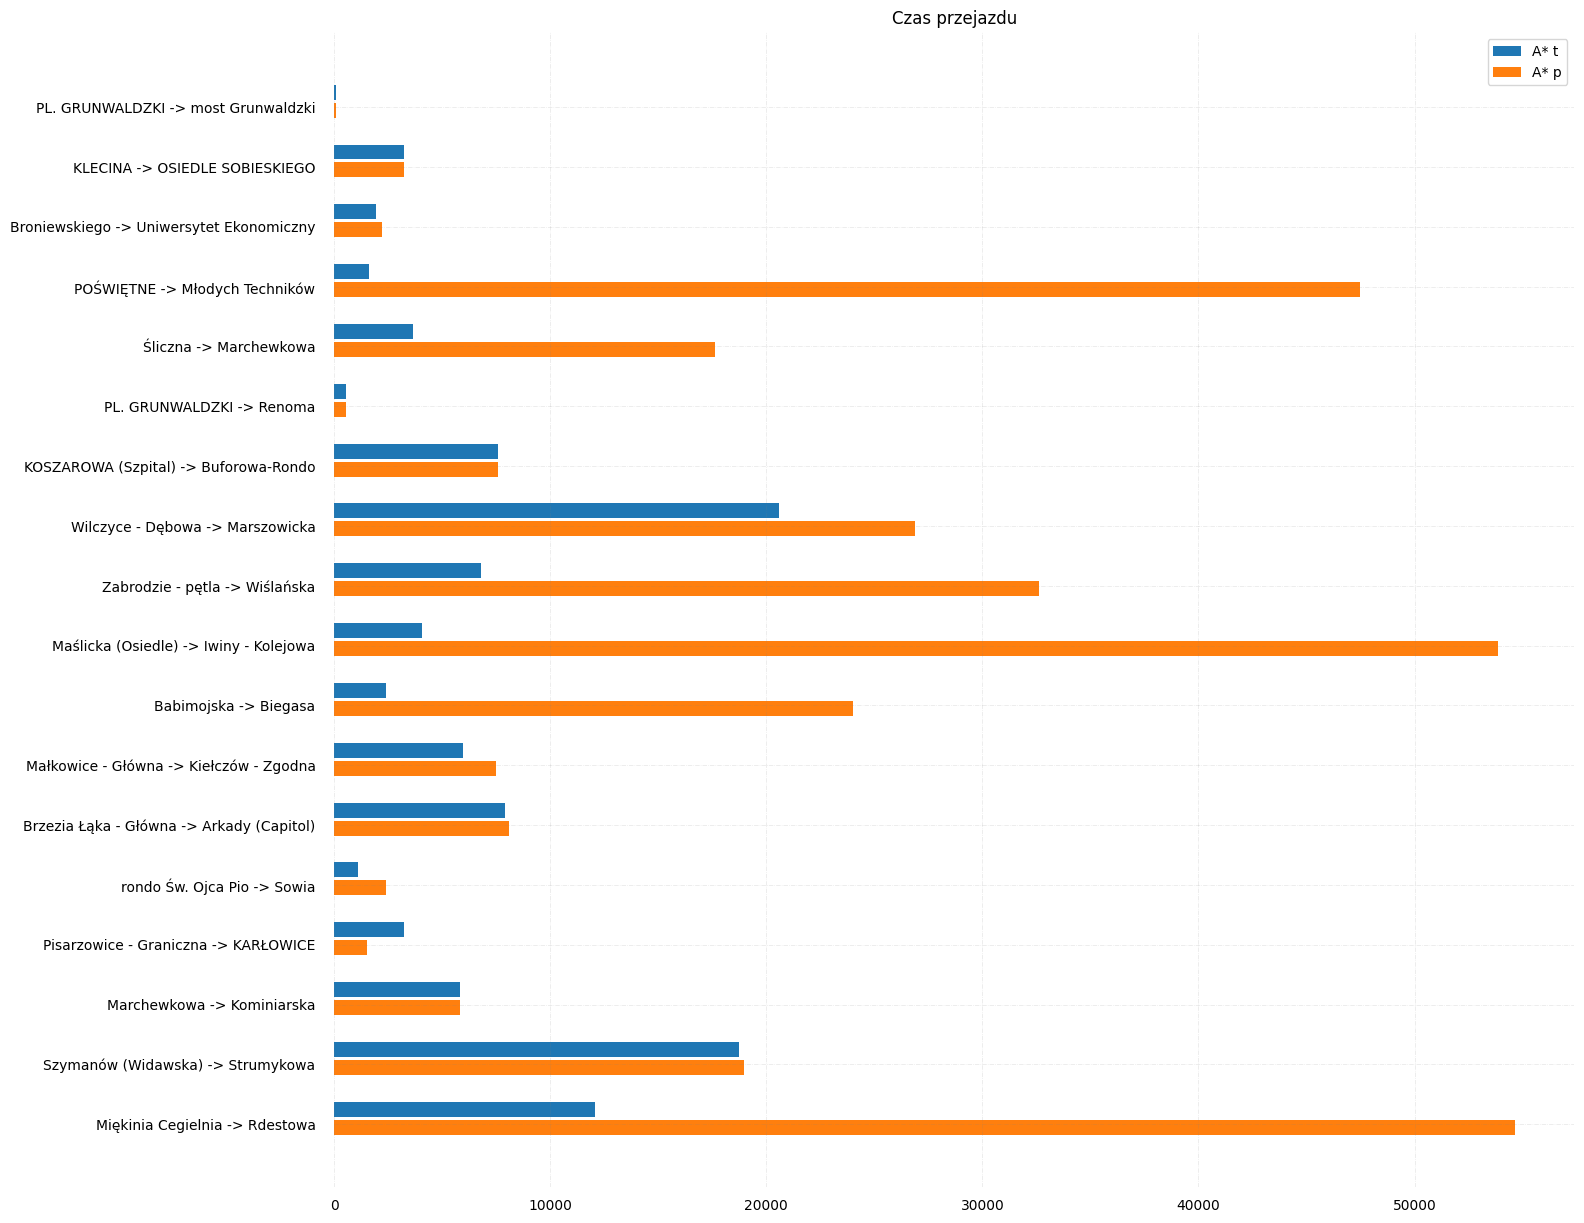

In [16]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=2, title='Czas przejazdu', formatter=time_to_normalized_sec, display_annotation=False)

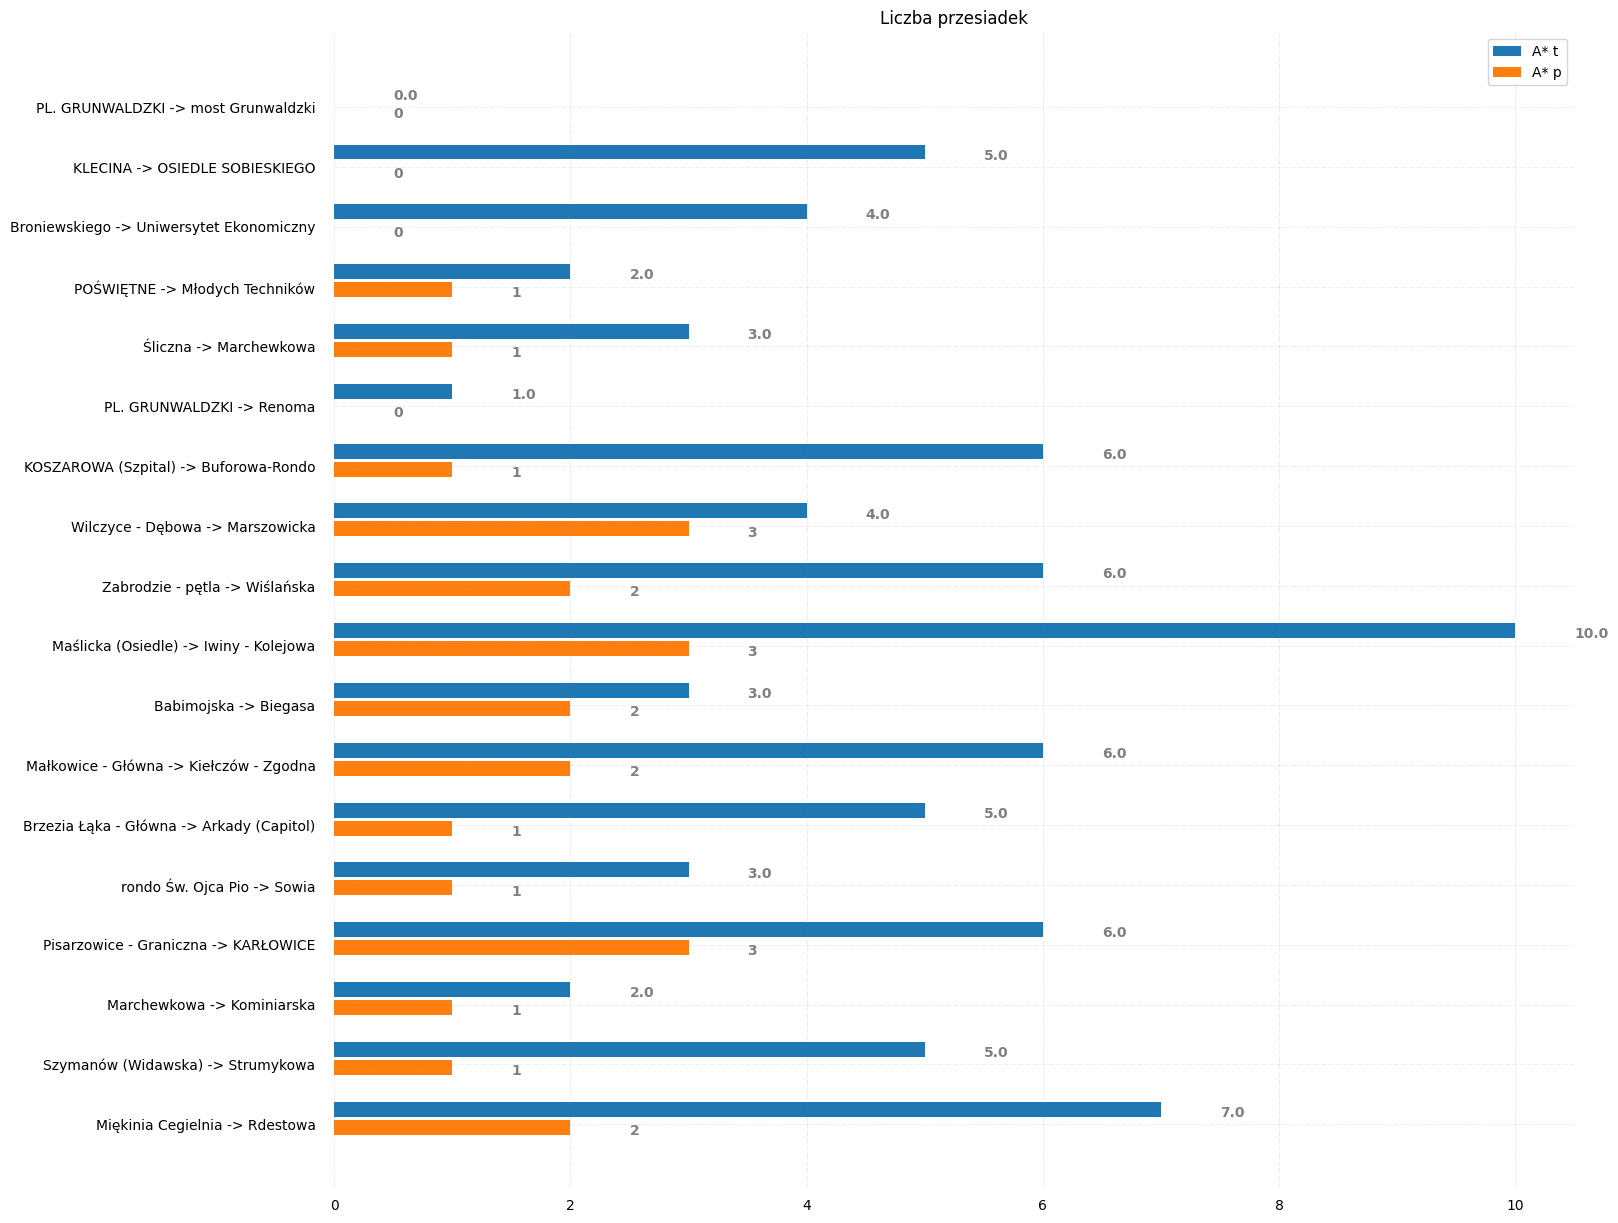

In [17]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=True)

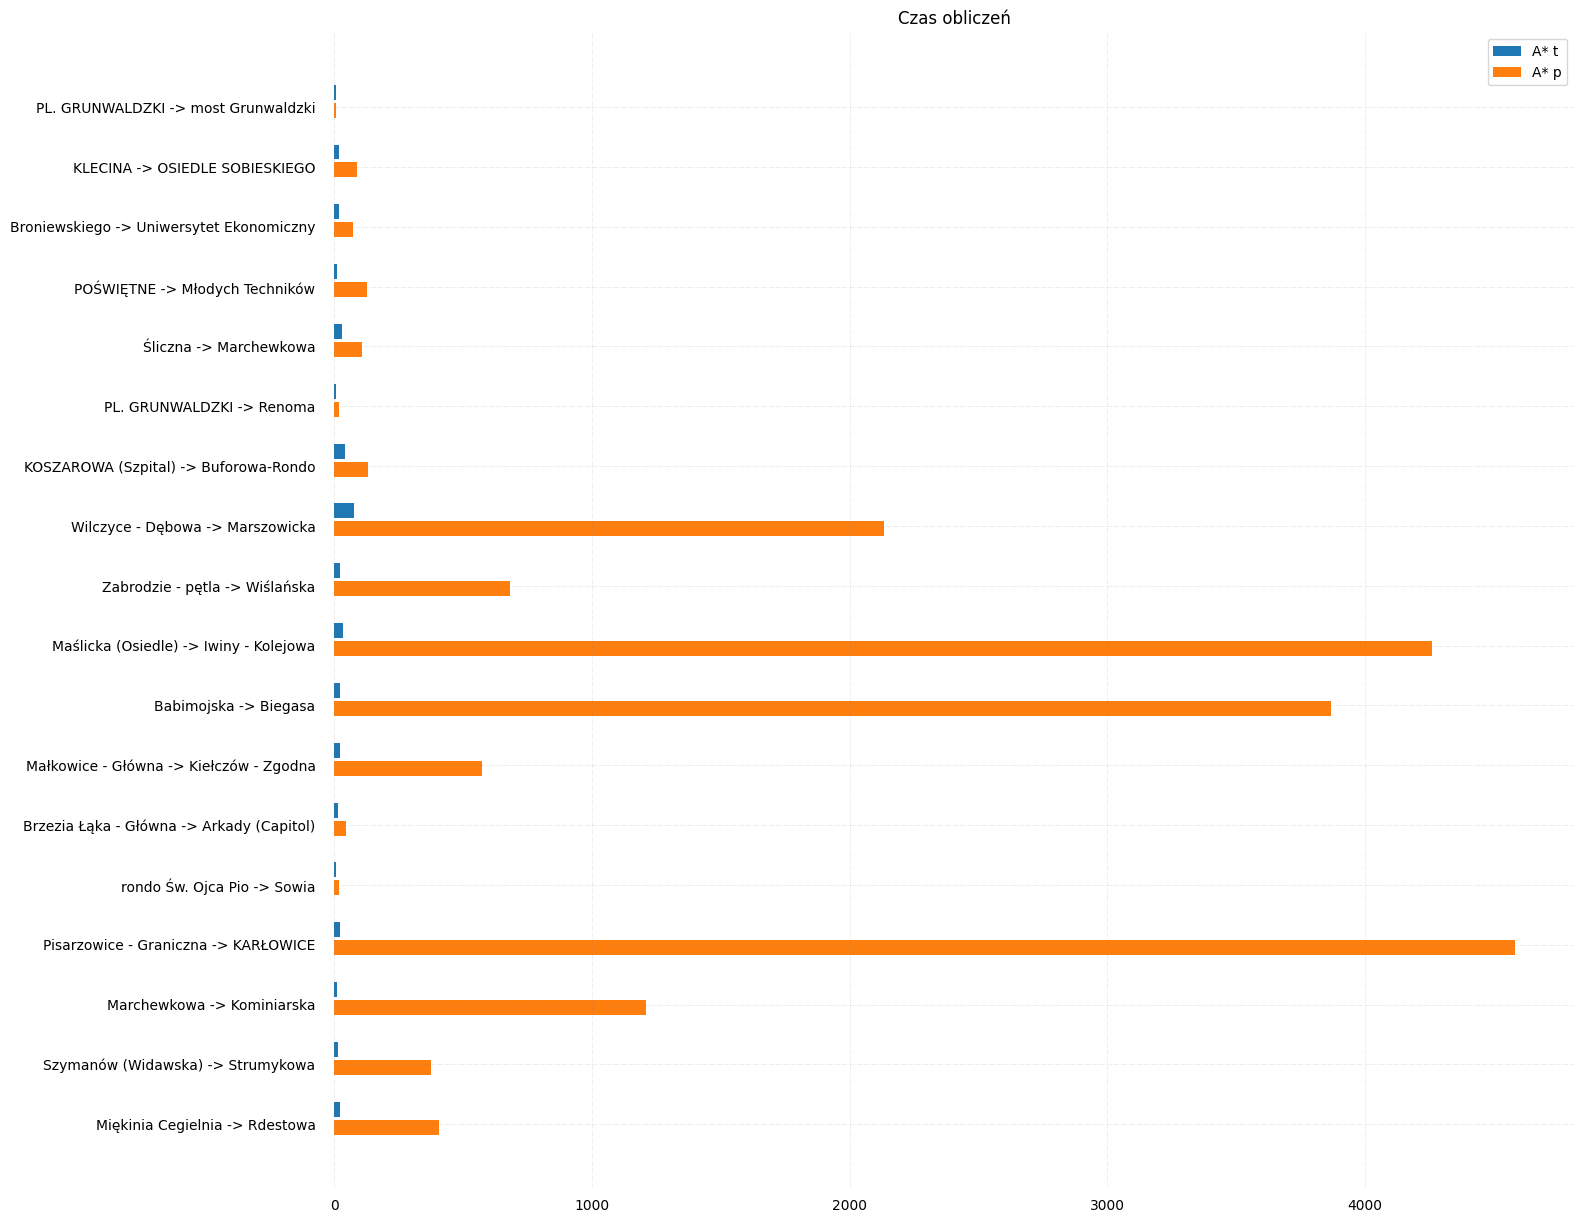

In [18]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

#### Modyfikacja - optymalizacja czasu i liczby przesiadek 

Modyfikacja dotyczyła zaimplementowania nowej funkcji kosztu i heurystyki, które liczą średnią ważoną kosztów czasu przejazdu i przesiadek A$^*$. Porównując wyniki do $A^* t$ można zauważyć, że odnajduje on prawie tak samo optymalne pod względem czasowym trasy, oraz w porównaniu do $A^*p$ modyfikuje liczbę przesiadek. Wagi dla obu strat zostały wybrane na 'oko', więc prawdopodobnie możliwe byłoby dobranie lepszych wartości tych hiperparametrów. 

In [19]:
a_star_t_custom = pd.read_csv(RESULTS / 'a-star-custom/summary0', names=header)

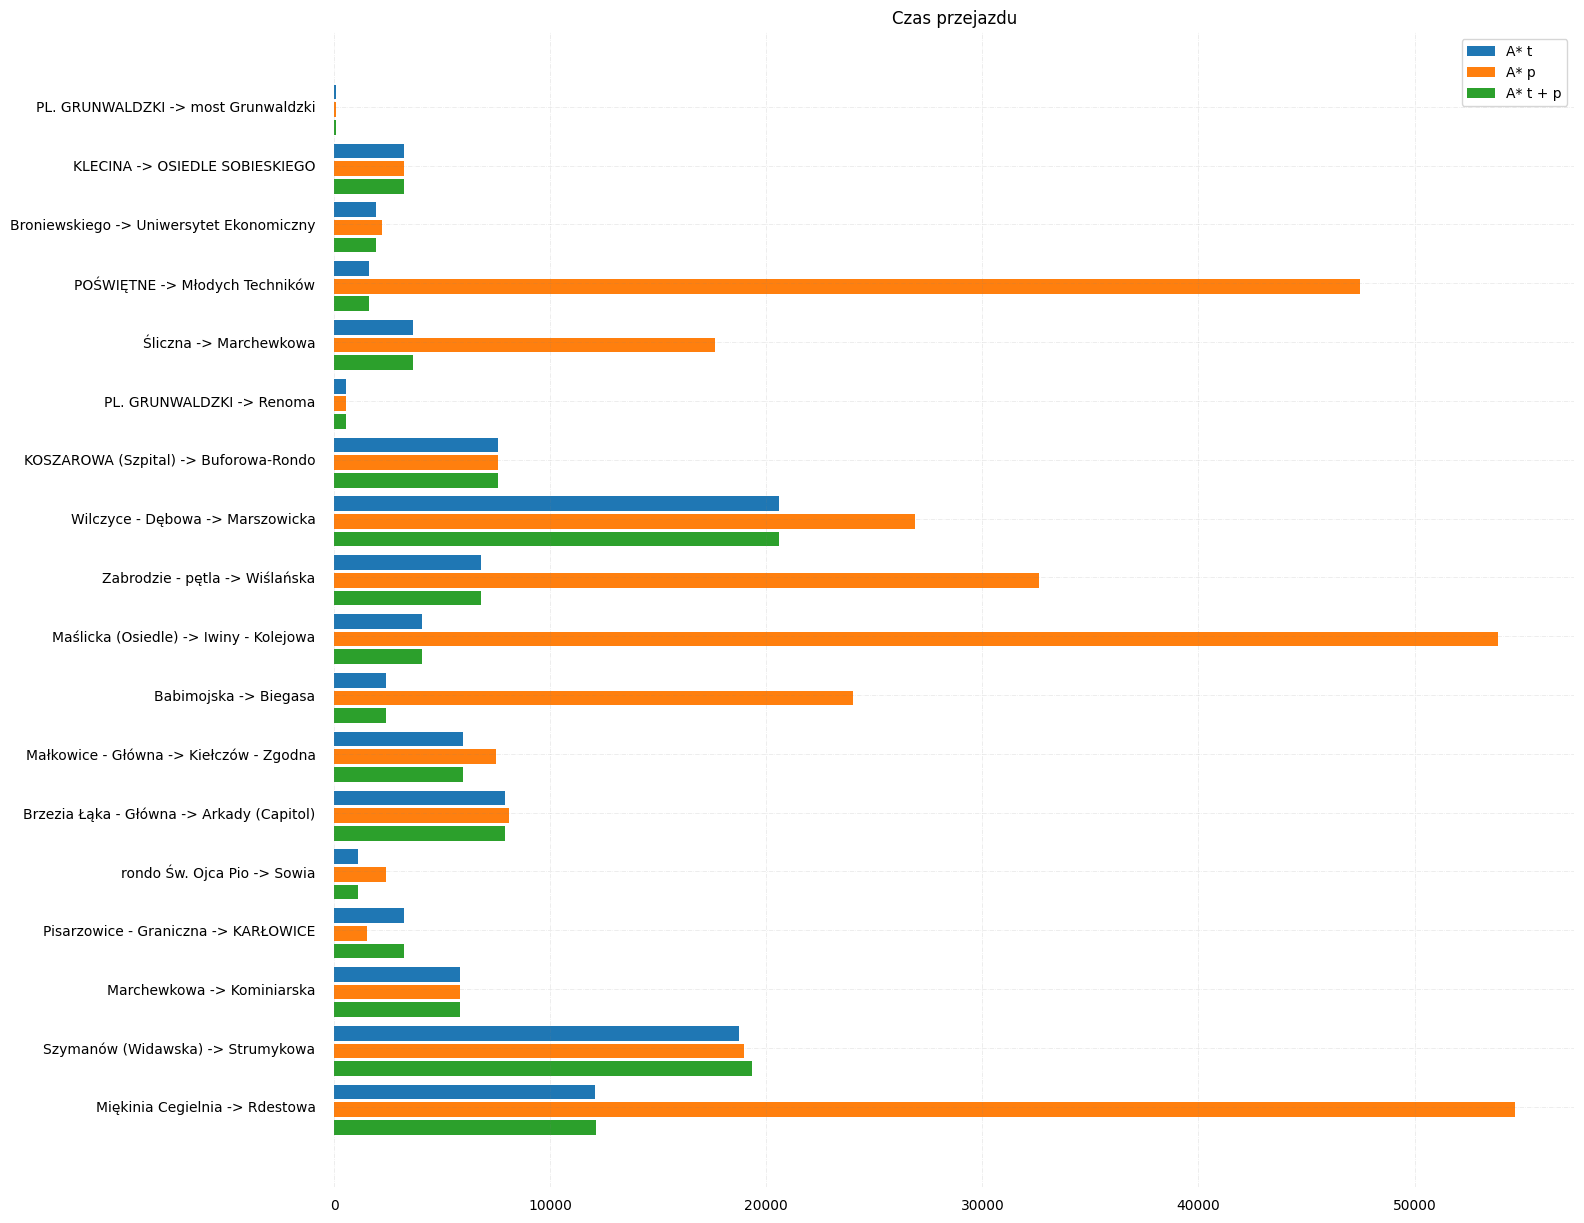

In [20]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=2, title='Czas przejazdu', formatter=time_to_normalized_sec, display_annotation=False)

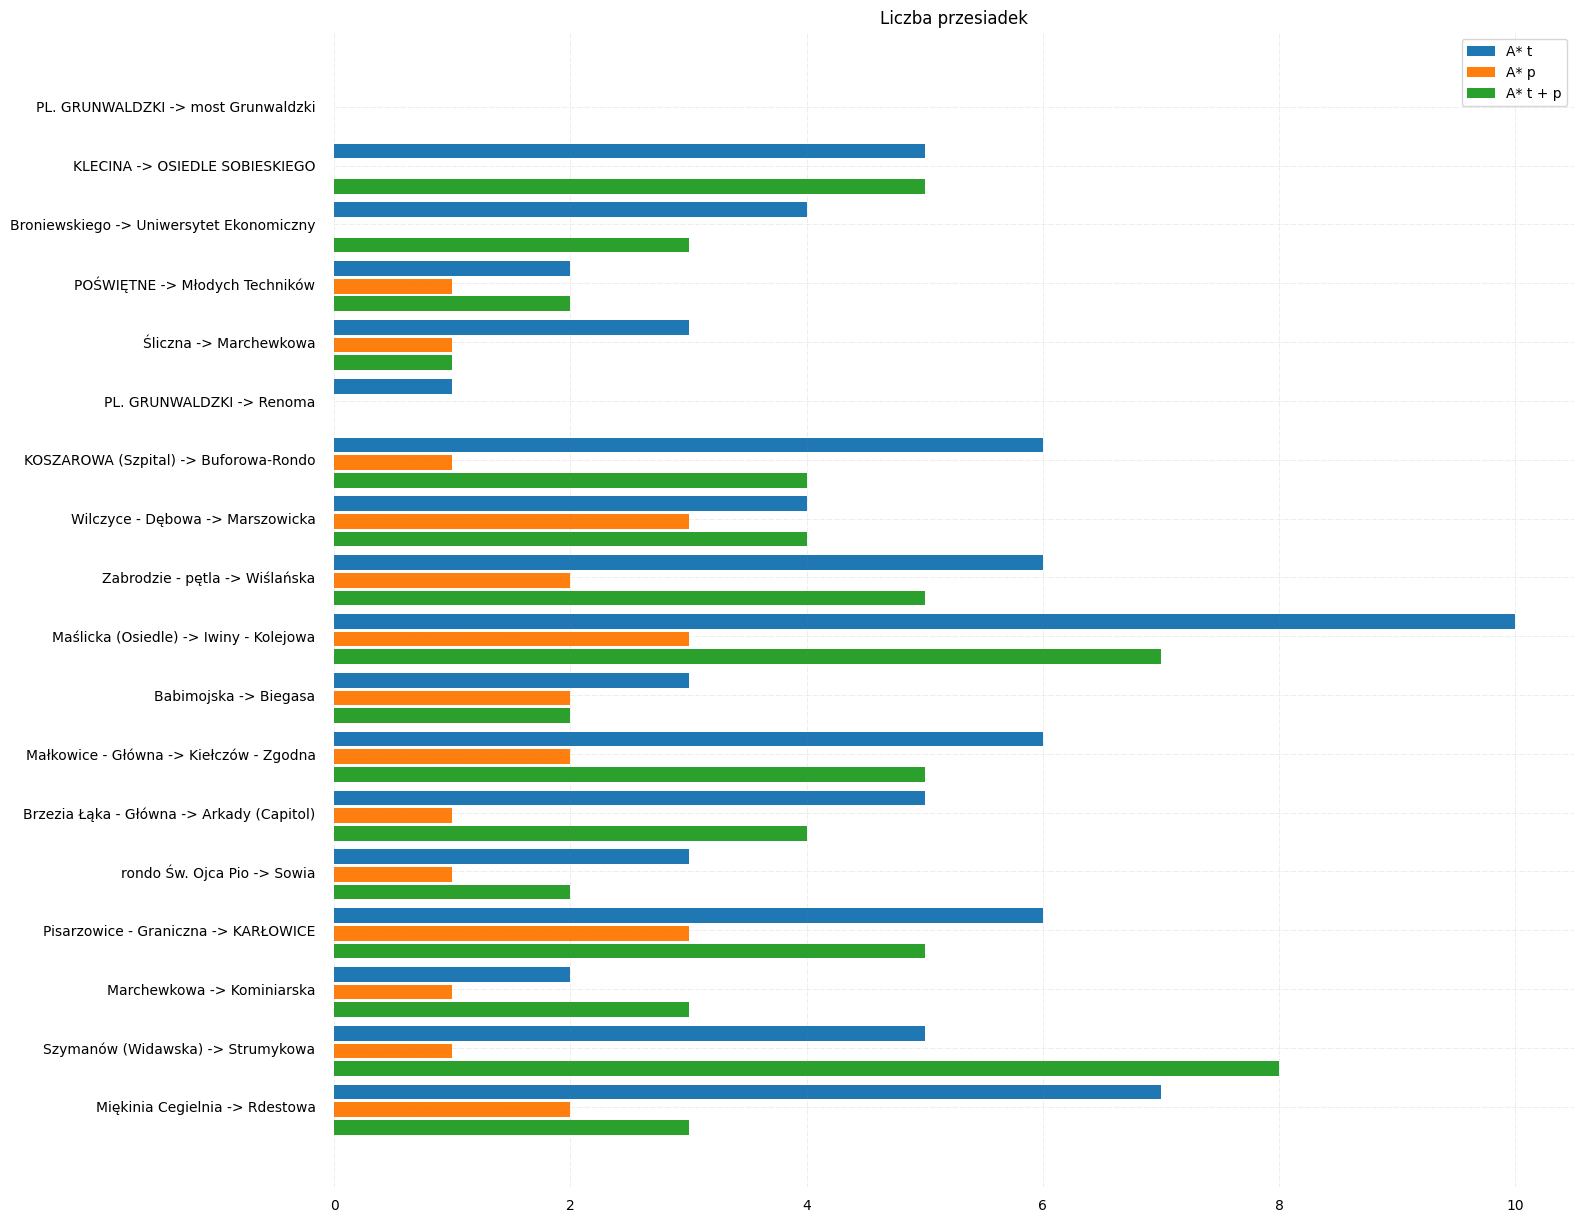

In [21]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=False)

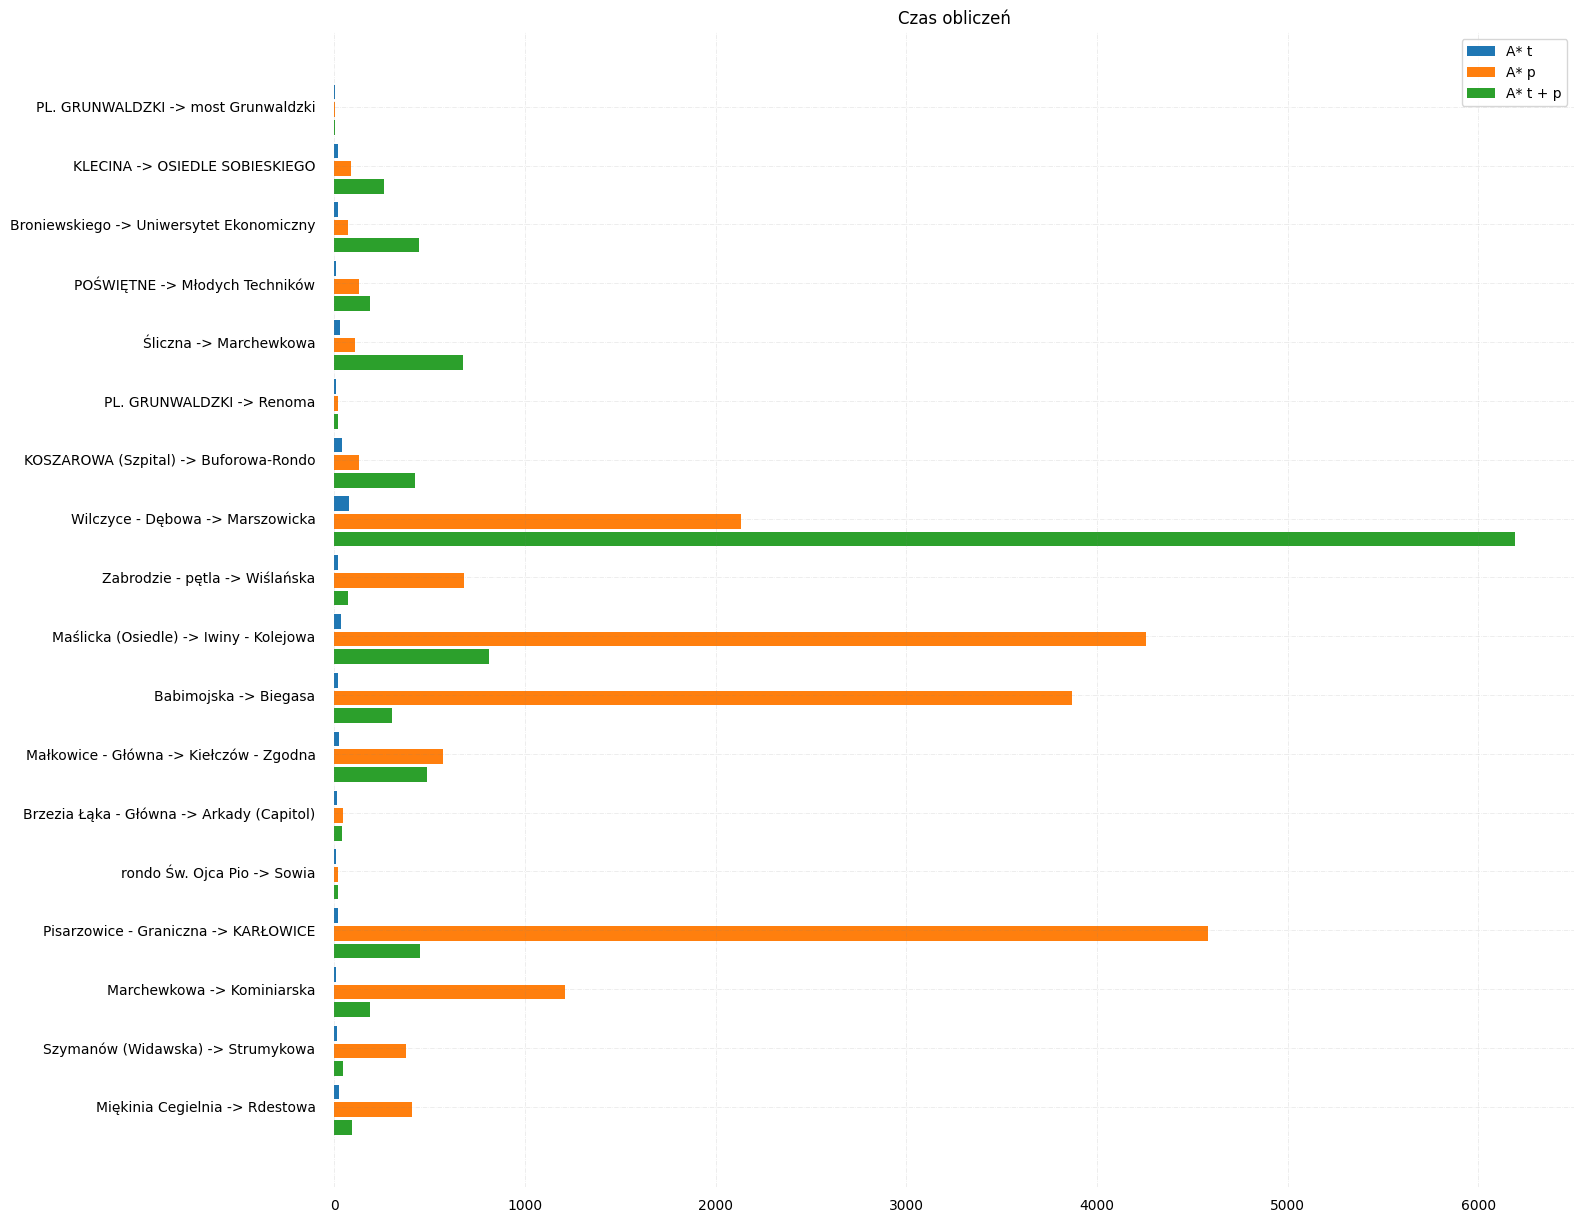

In [22]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

### Tabu Search